# Housing Price Prediction

As part of Kaggle's [Housing Price Prediction Competition](https://www.kaggle.com/c/home-data-for-ml-course), I created an XGBoost model to predict the final price of homes in Ames, Iowa. The model uses 79 predictor variables describing numerous aspects of residential homes. This type of analysis would be useful in the real estate industry and can be used by home buyers to find undervalued / overvalued houses.

#  
## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost
import missingno as msno 

#  
## Data Source

The data collected from Kaggle contains 79 features about *1460* houses in Ames.

In [2]:
# Read the data
X = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#  
## Exploratory Data Analysis (EDA)

For the EDA portion of this project I will analyze the relationship between Sale Price and possible predictor variables. I will also take a look at which columns have missing values.

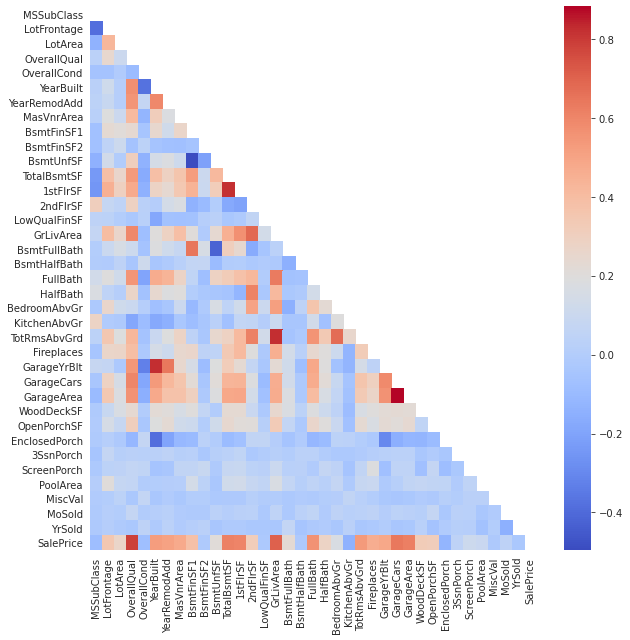

In [3]:
# Correlation matrix
correlations = X.corr()

# Heat map of correlation matrix
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(correlations,mask=mask,annot=False,cmap="coolwarm")

<AxesSubplot:>

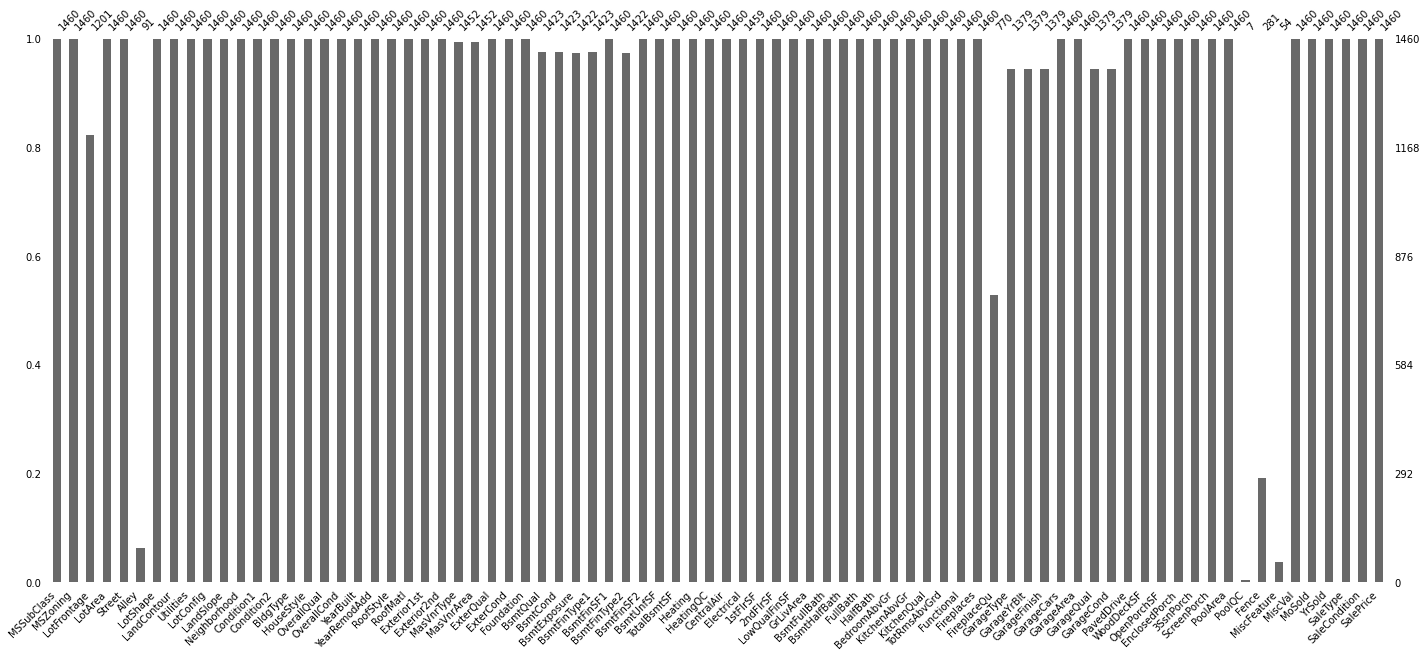

In [4]:
# Percentage of data with null values
msno.bar(X, fontsize=10, labels=True)

Key takeaways from EDA:
- No missing values for target variable (SalePrice)
- A lot of missing values for possible predictor variables, so I cannot simply remove rows or columns with missing values
- Many numerical variables appear to have a strong positive correlation with the target variable (SalePrice), especially OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF, YearBuilt, FullBath, and GarageArea

#  
## Data Cleaning

I will perform the following data cleaning steps:
- Seperate target variable (Sale Price) from predictor variables
- Split the data so that 80% of the data will be used to train the model and 20% will be used to validate the model
- Split columns into numerical columns and low cardinatlity categorical columns (columns with few unique values)
- Remove high cardinality categorical columns (columns with many unique values)

In [5]:
from sklearn.model_selection import train_test_split

# Separate target from predictors
y = X.SalePrice              
X = X.drop(['SalePrice'], axis=1)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Select categorical columns with relatively low cardinality
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

#  
## Feature Engineering (Data Preprocessing Pipeline)

I will create a data preprocessing pipeline that will:
- Impute missing numerical values with their respective median and missing categorical values with 'Other'
- One-hot encode all categorical variables with low cardinality which will create new columns indicating the presence (1) or absence (0) of each possible value in the data.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy = 'median')

# Preprocessing for low cardinality categorical data
low_cardinality_transformer = Pipeline(steps = [
    ('low_imputer', SimpleImputer(strategy = 'constant', fill_value = 'Other')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for numerical and low cardinality categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('low', low_cardinality_transformer, low_cardinality_cols)
    ])

#  
## Models (Parameter Tuning)

I will create a couple gradient boosted models with varying parameters. 

A small learning rate and large number of estimators tend to result in more accurate models. However, it will take longer to run. 

- n_estimators specifies how many times to go through the modeling cycle. It is equal to the number of models that we include in the ensemble.
    - Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
    - Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data.

Thus, I will try different combinations of n_estimators (100 to 1000) and learning_rate (0.01 to 0.1).

In [7]:
# XGBoost Models
from xgboost import XGBRegressor

xgb_model_1 = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb_model_4 = XGBRegressor(n_estimators=500, learning_rate=0.01)
xgb_model_5 = XGBRegressor(n_estimators=500, learning_rate=0.05)
xgb_model_6 = XGBRegressor(n_estimators=500, learning_rate=0.1)
xgb_model_7 = XGBRegressor(n_estimators=100, learning_rate=0.01)
xgb_model_8 = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model_9 = XGBRegressor(n_estimators=100, learning_rate=0.1)

I will fit the models to the training data (X_train and y_train). Since the dataset is not very large, I will evaluate each model using cross-validation which consists of running a model on different subsets of the data to get multiple measures of model quality which will produce a more accurate measure. Finally, I will select the model with the lowest average mean absolute error (MAE).

In [9]:
from sklearn.model_selection import cross_val_score

def get_mae(model, X_train, y_train):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
    model_pipeline.fit(X_train, y_train)
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(model_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    
    # Get the average MAE score across the 5 folds of data
    mae = scores.mean()
    
    return(mae)

# Compare mean absolute error (MAE) across different models
for model in [xgb_model_1, xgb_model_2, xgb_model_3, xgb_model_4, xgb_model_5, xgb_model_6, xgb_model_7, xgb_model_8, 
              xgb_model_9]:
    my_mae = get_mae(model, X_train, y_train)
    print("Average MAE Score: " + str(my_mae))

Average MAE Score: 16160.603499571918
Average MAE Score: 16362.877089576199
Average MAE Score: 16370.884554259417
Average MAE Score: 16544.251492936644
Average MAE Score: 16317.570368685789
Average MAE Score: 16364.807277397258
Average MAE Score: 68561.34651113013
Average MAE Score: 16695.590507277397
Average MAE Score: 16361.30399989298


#  
## Model Deployment

Since xgb_model_1 has the lowest average MAE score, I will apply it to the test set.

In [10]:
# Deploy model pipeline on new customer data set
deploy_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model_1)
                             ])

# Get sale price predictions
X_test['SalePricePrediction'] = deploy_model_pipeline.predict(X_test)
X_test.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePricePrediction
Id,,,,,,,,,,,,,,,,,,,,,
1461,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,...,140,0,0,0,120,0,0,6,2010,123990.156250
1462,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,393,36,0,0,0,0,12500,6,2010,150307.812500
1463,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,212,34,0,0,0,0,0,3,2010,190574.250000
1464,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,360,36,0,0,0,0,0,6,2010,190864.015625
1465,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,0,82,0,0,144,0,0,1,2010,194781.859375


#  
## Conclusion

After submitting my model to the Kaggle competition, I finished in the Top 7% with an MAE of under 15,000. In conclusion, the XGBRegressor and the predictor variables I selected effectively predicted house prices of homes in Ames, Iowa.